<a href="https://colab.research.google.com/github/nikhilnagar503/medical-image-segmentation-lab/blob/main/Retinal_Vessel_Extraction_using_Niblack_and_Sauvola_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install kagglehub opencv-python scikit-image matplotlib numpy pandas tqdm

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.color import rgb2gray
from skimage import img_as_ubyte

from sklearn.metrics import confusion_matrix
from tqdm import tqdm


In [30]:
path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")

print("Dataset Path:", path)

Using Colab cache for faster access to the 'drive-digital-retinal-images-for-vessel-extraction' dataset.
Dataset Path: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction


In [31]:
train_images = os.path.join(path, "DRIVE/training/images")

train_manual = os.path.join(path, "DRIVE/training/1st_manual")

train_mask = os.path.join(path, "DRIVE/training/mask")

print("Images:", len(os.listdir(train_images)))


Images: 20


In [32]:
def load_image(path):

    img = cv2.imread(path)

    green = img[:,:,1]

    return green


In [33]:
def load_ground_truth(path):

    gt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    gt = gt > 0

    return gt.astype(np.uint8)


In [34]:
def load_fov_mask(path):

    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    mask = mask > 0

    return mask.astype(np.uint8)

In [35]:
def niblack_threshold(image):

    thresh = threshold_niblack(
        image,
        window_size=25,
        k=0.2
    )

    binary = image < thresh   # FIXED

    return binary.astype(np.uint8)


In [36]:
def sauvola_threshold(image):

    thresh = threshold_sauvola(
        image,
        window_size=25
    )

    binary = image < thresh   # FIXED

    return binary.astype(np.uint8)


In [37]:
def sensitivity(gt, pred, mask):

    gt = gt[mask == 1]

    pred = pred[mask == 1]

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()

    return tp / (tp + fn)


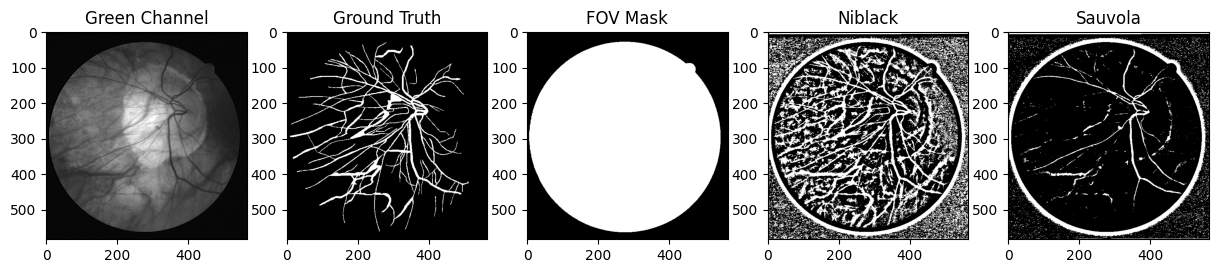

In [38]:
file = os.listdir(train_images)[0]

img_path = os.path.join(train_images, file)

gt_name = file.replace("_training.tif", "_manual1.gif")

mask_name = file.replace("_training.tif", "_training_mask.gif")

gt_path = os.path.join(train_manual, gt_name)

mask_path = os.path.join(train_mask, mask_name)


image = load_image(img_path)

gt = load_ground_truth(gt_path)

fov = load_fov_mask(mask_path)

niblack = niblack_threshold(image)

sauvola = sauvola_threshold(image)


plt.figure(figsize=(15,5))

plt.subplot(1,5,1)
plt.imshow(image, cmap='gray')
plt.title("Green Channel")

plt.subplot(1,5,2)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")

plt.subplot(1,5,3)
plt.imshow(fov, cmap='gray')
plt.title("FOV Mask")

plt.subplot(1,5,4)
plt.imshow(niblack, cmap='gray')
plt.title("Niblack")

plt.subplot(1,5,5)
plt.imshow(sauvola, cmap='gray')
plt.title("Sauvola")

plt.show()


In [39]:
niblack_scores = []

sauvola_scores = []

files = os.listdir(train_images)

for file in tqdm(files):

    img_path = os.path.join(train_images, file)

    gt_name = file.replace("_training.tif", "_manual1.gif")

    mask_name = file.replace("_training.tif", "_training_mask.gif")

    gt_path = os.path.join(train_manual, gt_name)

    mask_path = os.path.join(train_mask, mask_name)


    image = load_image(img_path)

    gt = load_ground_truth(gt_path)

    fov = load_fov_mask(mask_path)


    niblack = niblack_threshold(image)

    sauvola = sauvola_threshold(image)


    n_score = sensitivity(gt, niblack, fov)

    s_score = sensitivity(gt, sauvola, fov)


    niblack_scores.append(n_score)

    sauvola_scores.append(s_score)


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


In [40]:
niblack_avg = np.mean(niblack_scores)

sauvola_avg = np.mean(sauvola_scores)

print("FINAL RESULTS")
print("-------------")

print("Niblack Sensitivity :", niblack_avg)

print("Sauvola Sensitivity :", sauvola_avg)


FINAL RESULTS
-------------
Niblack Sensitivity : 0.803371522137069
Sauvola Sensitivity : 0.17539286809610577


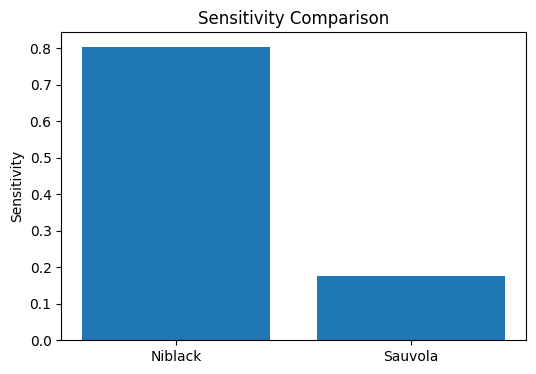

In [41]:
methods = ["Niblack", "Sauvola"]

scores = [niblack_avg, sauvola_avg]

plt.figure(figsize=(6,4))

plt.bar(methods, scores)

plt.title("Sensitivity Comparison")

plt.ylabel("Sensitivity")

plt.show()


# Conclusion

In this experiment, retinal vessel extraction was performed on the DRIVE dataset using two local adaptive thresholding methods: **Niblack** and **Sauvola**. The performance of both methods was evaluated using **sensitivity**, which measures the ability of the algorithm to correctly detect vessel pixels.

The experimental results showed that:

- **Niblack Sensitivity:** 0.803  
- **Sauvola Sensitivity:** 0.175  

These results indicate that **Niblack thresholding performed significantly better than Sauvola thresholding** for retinal vessel extraction in this experiment.

The main reason for this difference lies in how each method calculates its threshold and responds to local intensity variations. Retinal vessels are **thin, dark, and low-contrast structures**. Niblack thresholding calculates the threshold based directly on the local mean and standard deviation, making it more sensitive to small intensity variations. This allows Niblack to detect thin vessels more effectively.

In contrast, Sauvola thresholding applies a stricter normalization factor in its threshold calculation. This can cause the threshold to become too restrictive in low-contrast regions, resulting in many thin vessels being missed. As a result, Sauvola produces lower sensitivity in this case.

Therefore, based on the sensitivity metric and experimental results, **Niblack thresholding is more effective than Sauvola thresholding for extracting thin retinal vessels from the DRIVE dataset in this implementation.**
